<a href="https://colab.research.google.com/github/beratbb13/Colab/blob/main/ColabCustomObjectDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Apr 13 07:02:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()

/content


In [4]:
print(HOME)

/content


In [5]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.3/112.6 GB disk)


In [6]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 5.35M/5.35M [00:00<00:00, 84.3MB/s]
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 104k/104k [00:00<00:00, 94.4MB/s]
image 1/1 /content/dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 77.6ms
Speed: 14.7ms preprocess, 77.6ms inference, 423.5ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [16]:
from IPython.display import Image as IPyImage

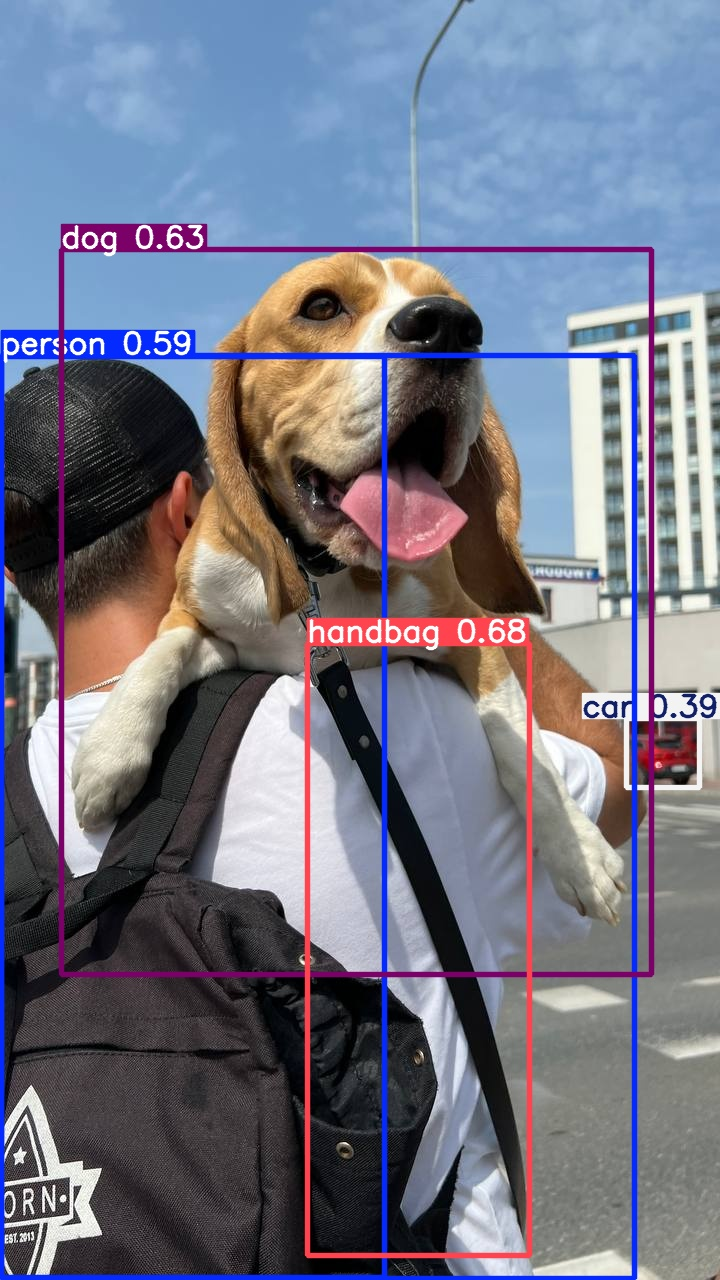

In [24]:
#os.listdir(f'{HOME}/runs/detect/predict')
IPyImage(filename=f'{HOME}/runs/detect/predict/dog.jpg', width=600)

In [25]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 54.9ms
Speed: 3.6ms preprocess, 54.9ms inference, 173.9ms postprocess per image at shape (1, 3, 640, 384)


In [26]:
result.boxes.xyxy

tensor([[3.0705e+02, 6.4341e+02, 5.2919e+02, 1.2558e+03],
        [6.1400e+01, 2.4994e+02, 6.5165e+02, 9.7412e+02],
        [1.7803e+00, 3.5551e+02, 6.3404e+02, 1.2788e+03],
        [1.1933e+00, 3.5620e+02, 3.8455e+02, 1.2776e+03],
        [6.2615e+02, 7.1818e+02, 6.9975e+02, 7.8754e+02]], device='cuda:0')

In [27]:
result.boxes.conf

tensor([0.6832, 0.6284, 0.5941, 0.3923, 0.3875], device='cuda:0')

In [28]:
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')

In [30]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

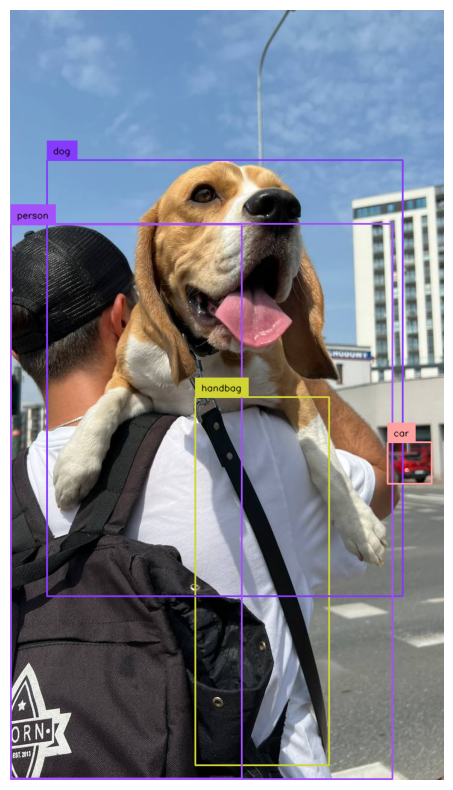

In [31]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

In [39]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("liangdianzhong")
project = workspace.project("-qvdww")
version = project.version(3)
dataset = version.download("yolov11")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
ROBOFLOW_API_KEY ITWKLR6NeRZSs2pVkJqY
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 两点钟模型-3 in yolov11:: 100%|██████████| 2612/2612 [00:00<00:00, 6669.40it/s]


In [40]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 134MB/s] 
New https://pypi.org/project/ultralytics/8.3.107 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/两点钟模型-3/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=No

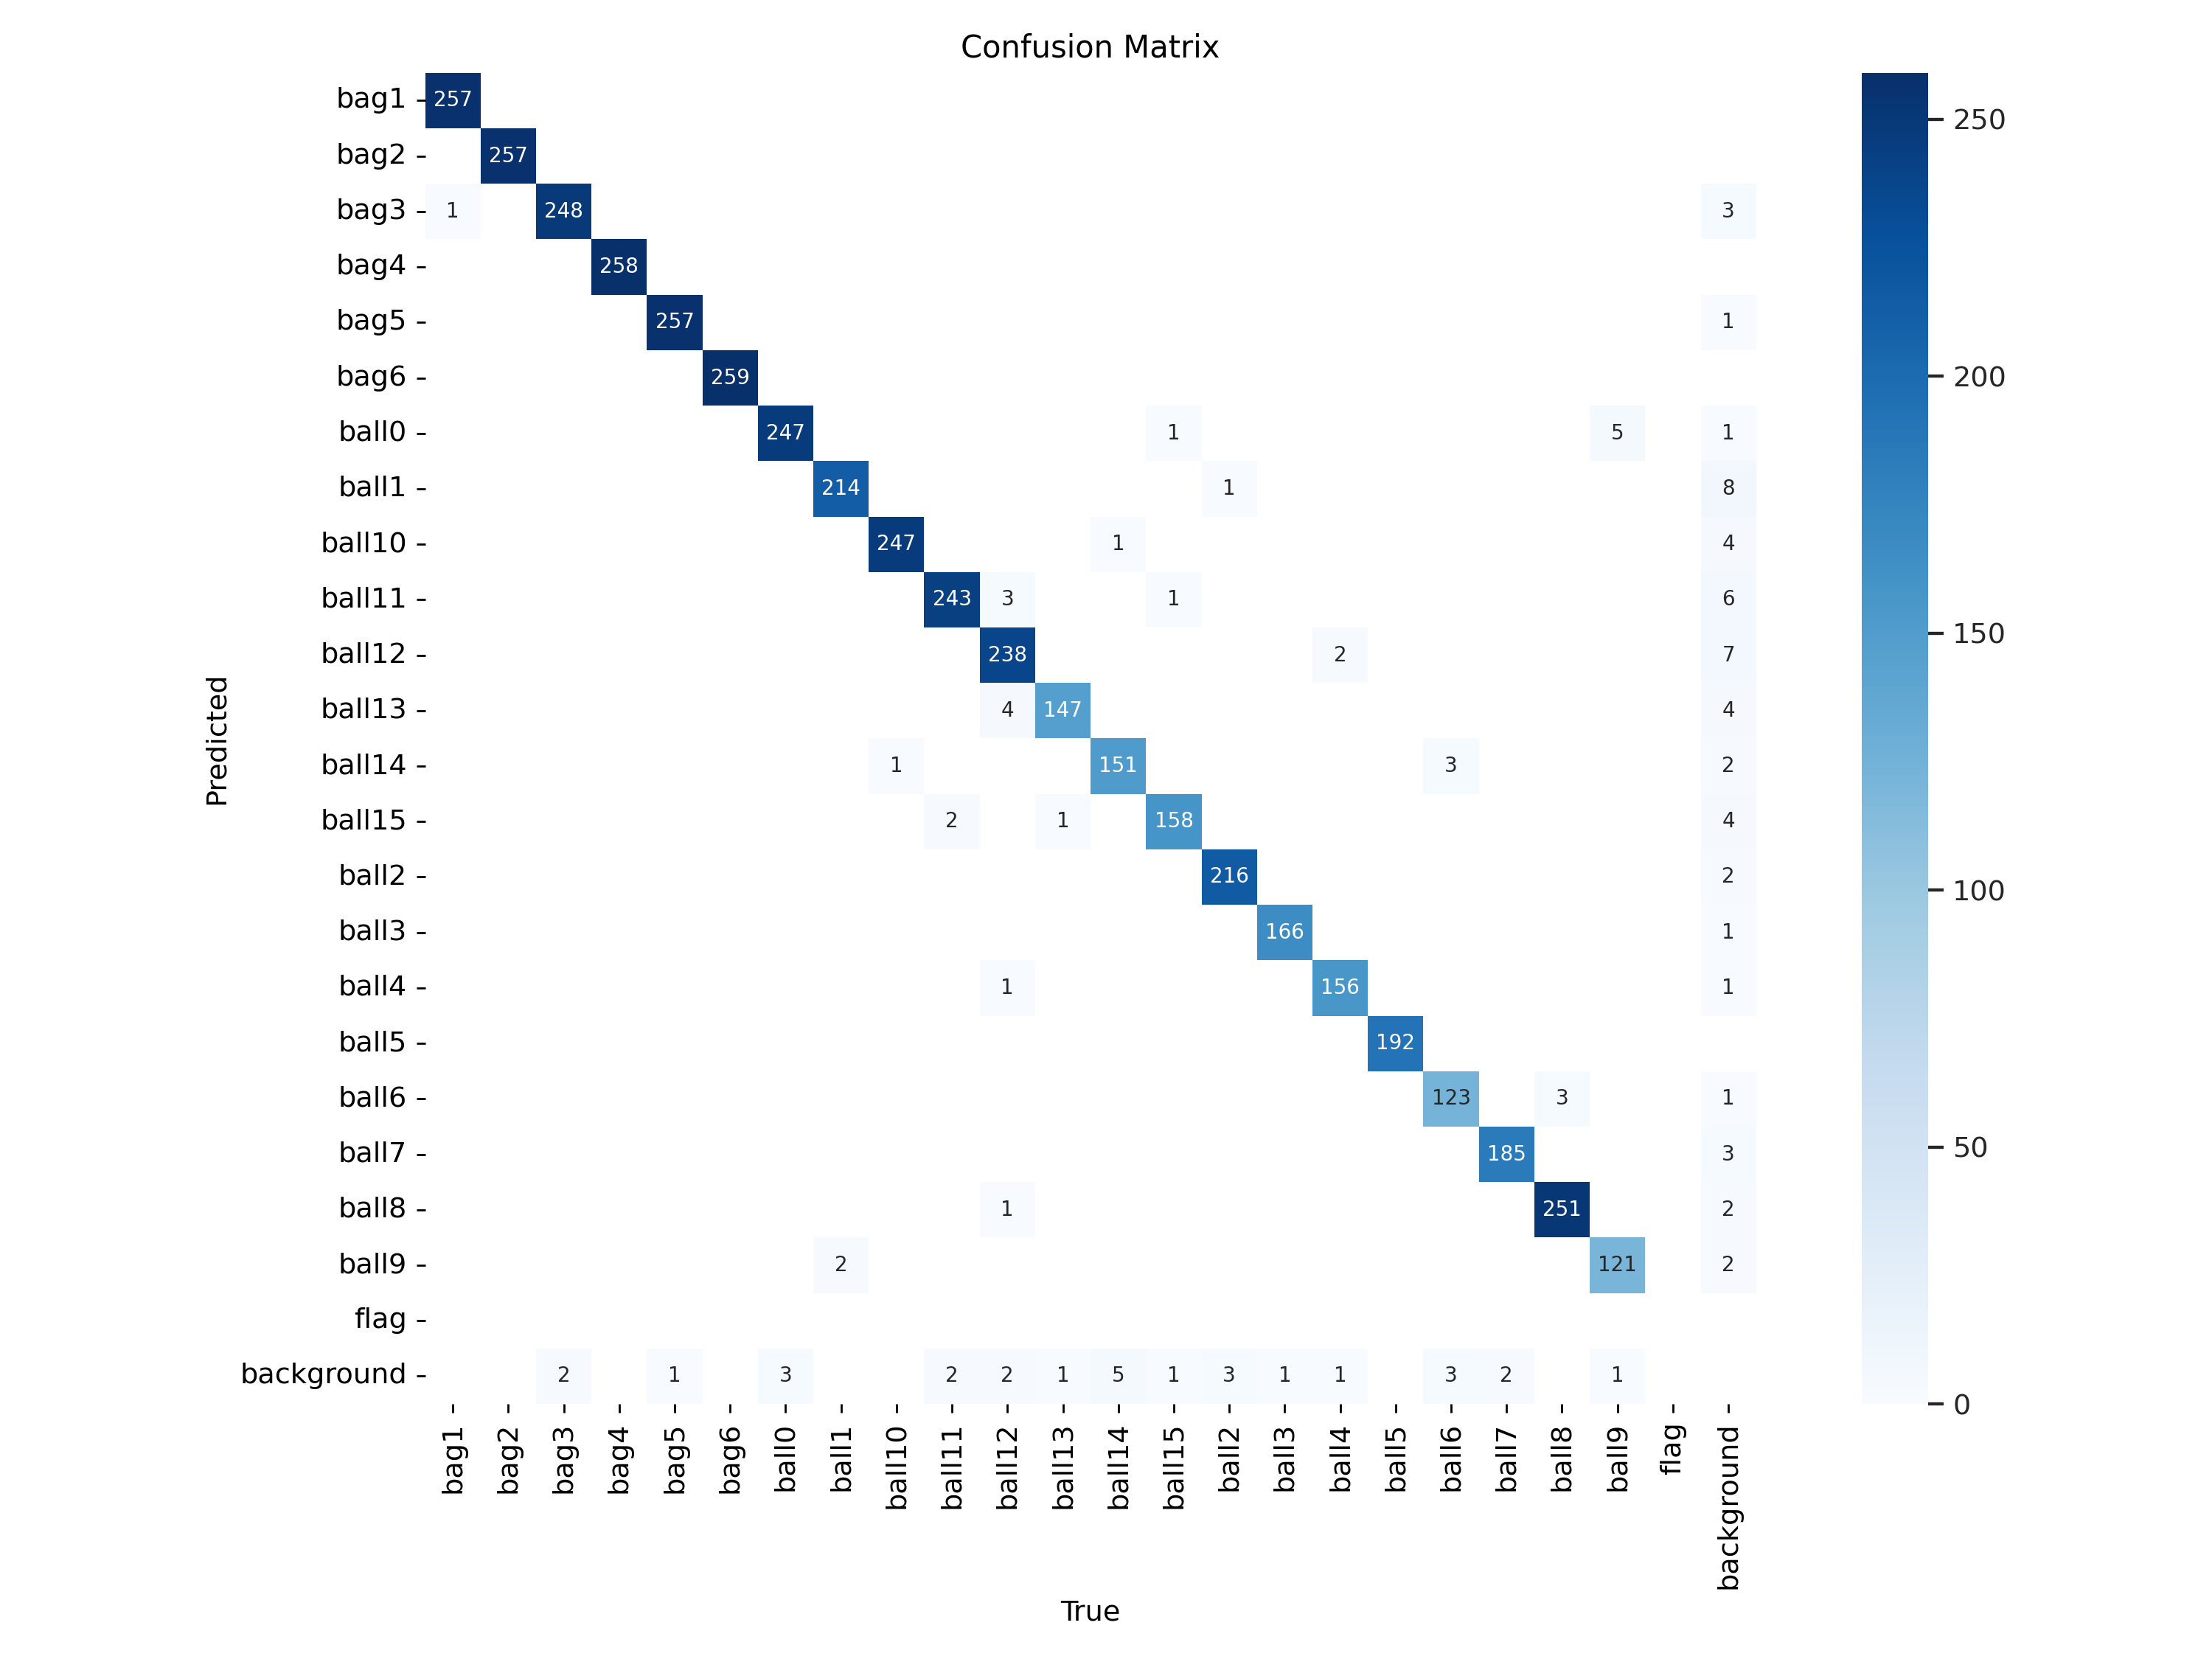

In [41]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

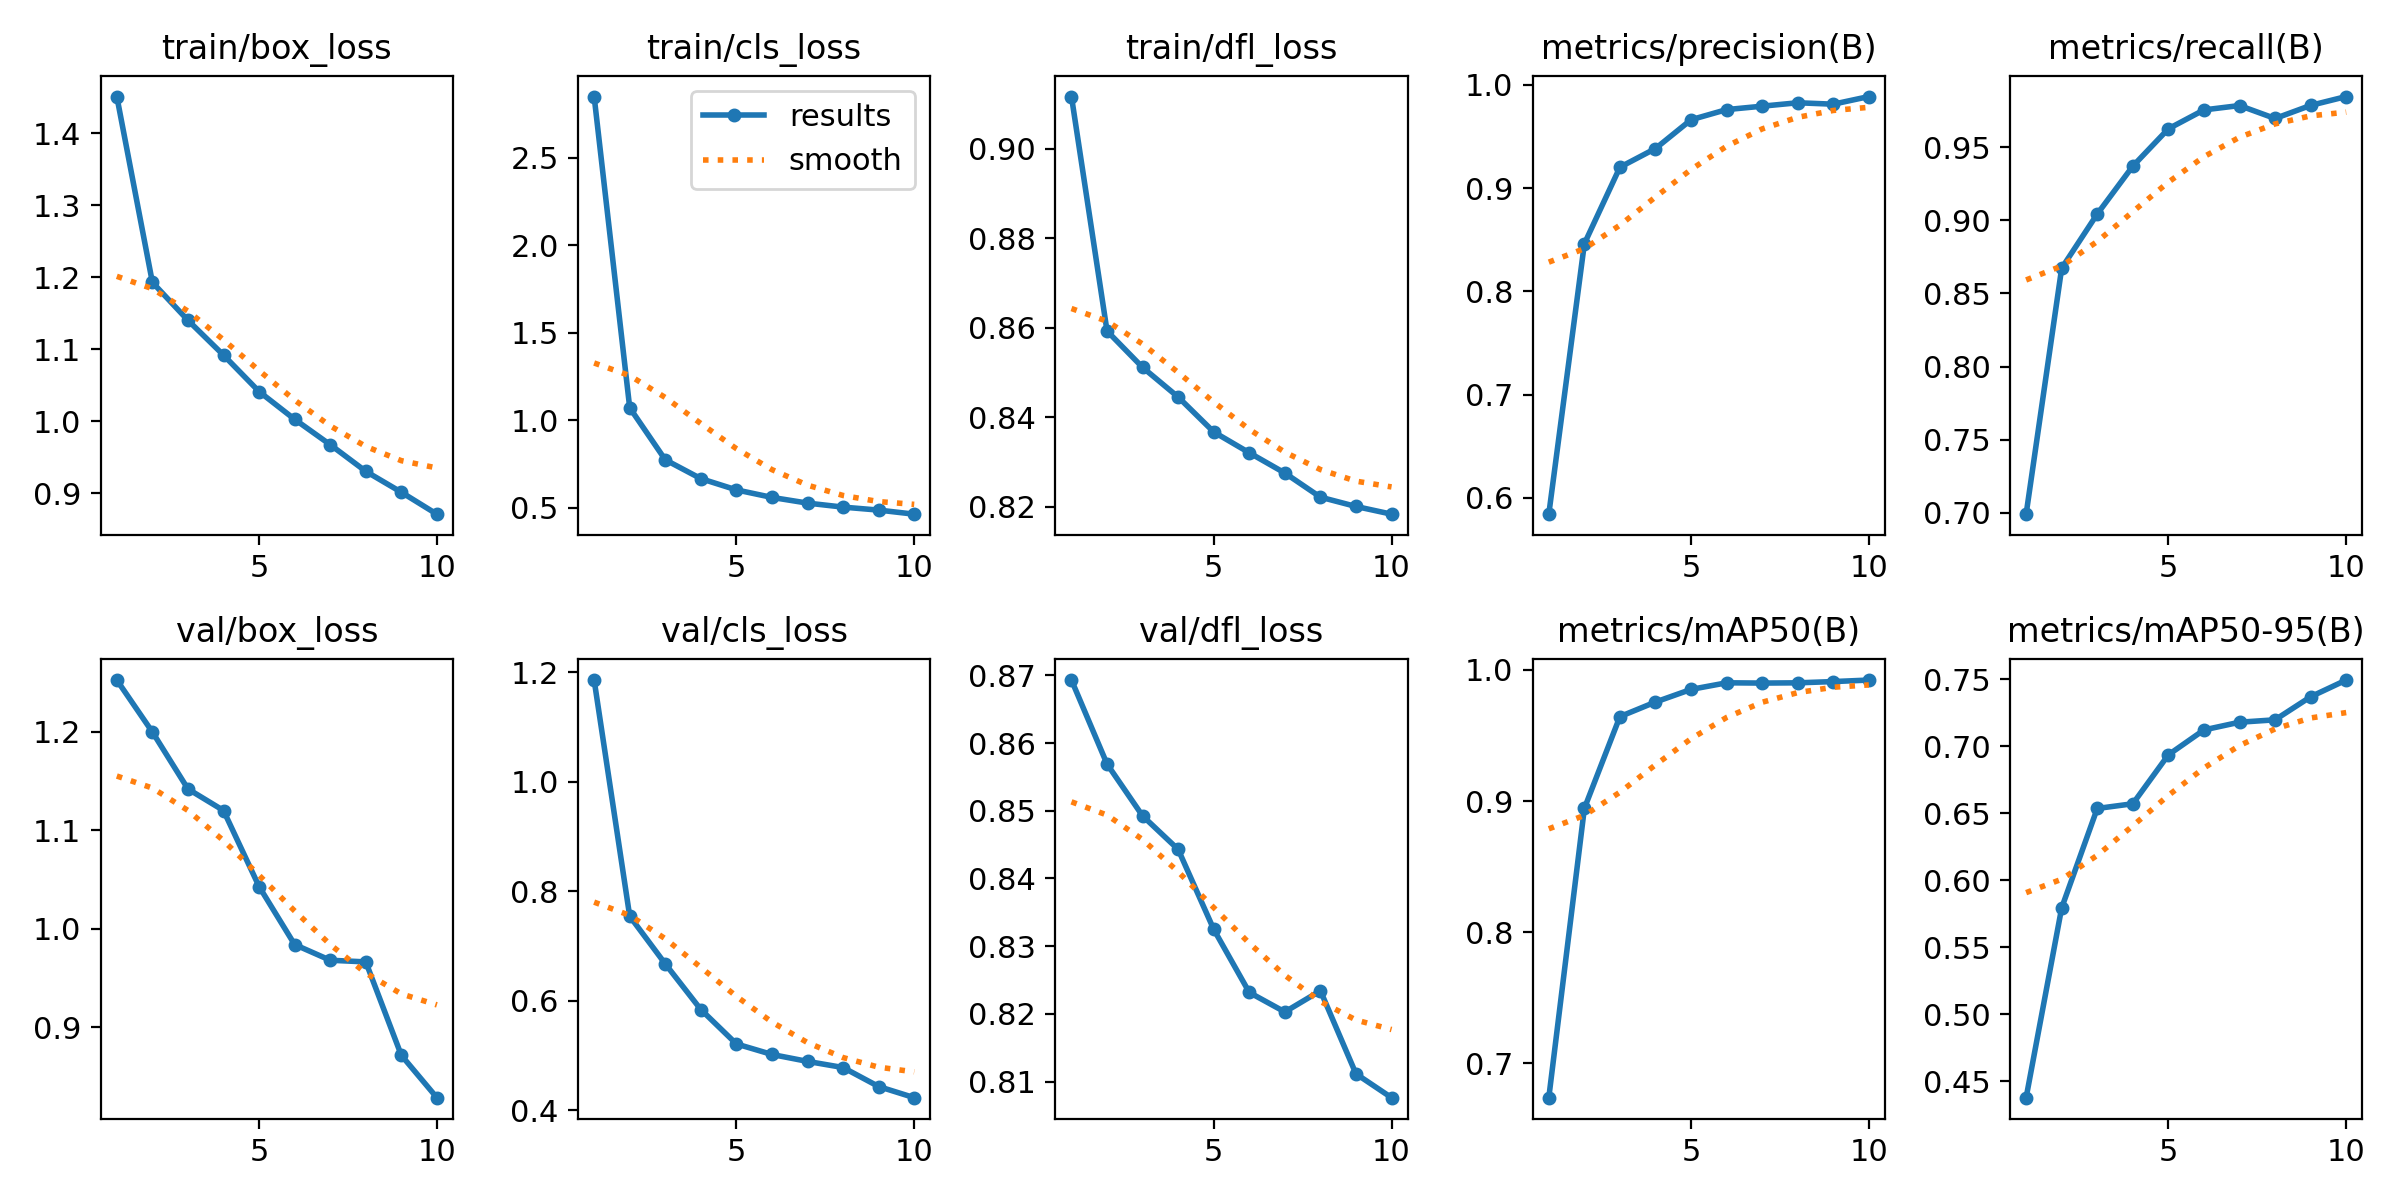

In [42]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

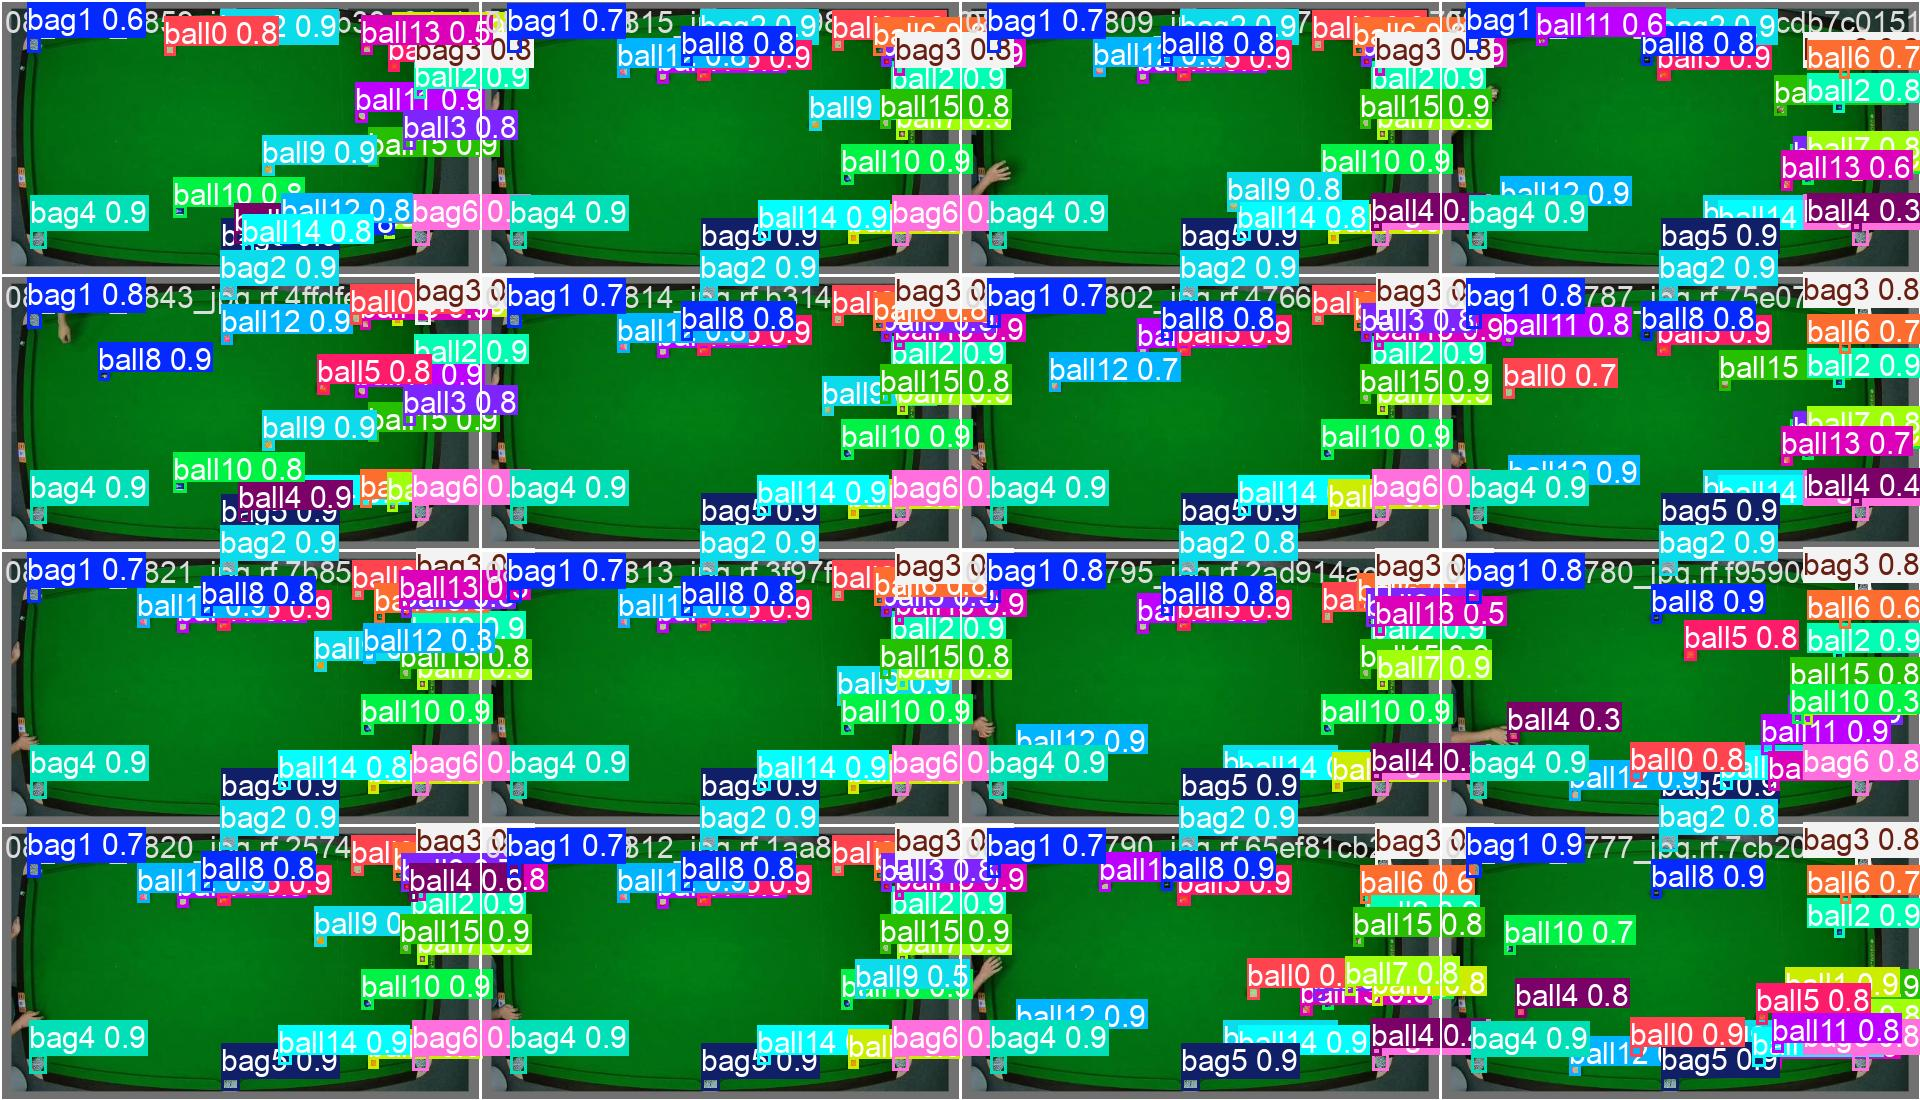

In [43]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [44]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,421,701 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/两点钟模型-3/valid/labels.cache... 259 images, 0 backgrounds, 0 corrupt: 100% 259/259 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/datasets/两点钟模型-3/valid/images/08_21C_0250_jpg.rf.b164fca68a7a644a126019aa776912c1.jpg: 2 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 17/17 [00:05<00:00,  2.95it/s]
                   all        259       4652      0.989      0.985      0.992      0.751
                  bag1        258        258          1      0.998      0.995      0.778
                  bag2        257        257      0.997          1      0.995      0.893
                  bag3        250        250      0.996      0.988      0.995      0.813
                  bag4        258        258      0.998          1      0.995      

In [45]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,421,701 parameters, 0 gradients, 21.3 GFLOPs

image 1/130 /content/datasets/两点钟模型-3/test/images/08_21A_0007_jpg.rf.9e8959e1a1730f1c5c940d000b3d416c.jpg: 384x640 1 bag1, 1 bag2, 1 bag3, 1 bag4, 1 bag5, 1 bag6, 1 ball10, 2 ball12s, 1 ball2, 1 ball5, 1 ball8, 49.9ms
image 2/130 /content/datasets/两点钟模型-3/test/images/08_21A_0008_jpg.rf.2dd16a0099bef3498fc559918545a9bd.jpg: 384x640 1 bag1, 1 bag2, 1 bag3, 1 bag4, 1 bag5, 1 bag6, 1 ball0, 1 ball10, 2 ball12s, 1 ball2, 1 ball5, 1 ball8, 10.9ms
image 3/130 /content/datasets/两点钟模型-3/test/images/08_21A_0022_jpg.rf.fe9e24fff670ceb0338b20bd49351eda.jpg: 384x640 1 bag1, 1 bag2, 1 bag3, 1 bag4, 1 bag5, 1 bag6, 1 ball0, 1 ball10, 1 ball12, 1 ball2, 1 ball5, 1 ball8, 10.9ms
image 4/130 /content/datasets/两点钟模型-3/test/images/08_21A_0088_jpg.rf.822feee76db82a3f805ca5dfd2a4f19c.jpg: 384x640 1 bag1, 1 bag2, 1 bag3, 1 bag4, 1 bag5, 1 bag6,

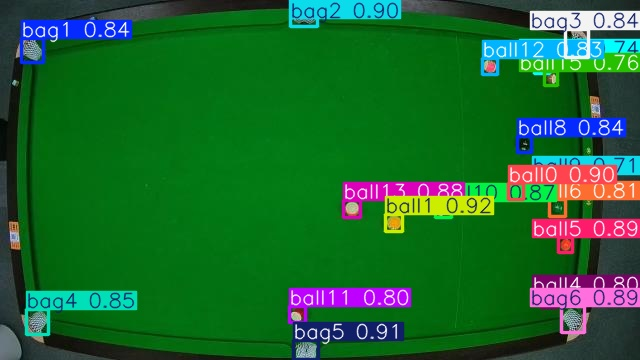

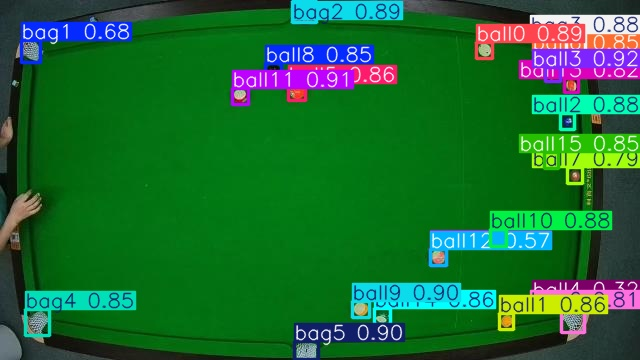

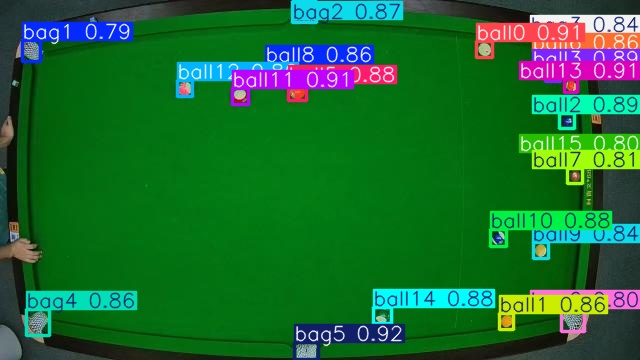

In [46]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [50]:
print(f"project.version(dataset.version) :", project.version(dataset.version))
#project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

project.version(dataset.version) : {
  "name": "\u4e24\u70b9\u949f\u6a21\u578b",
  "type": "object-detection",
  "version": "3",
  "augmentation": {},
  "created": 1725498937.854,
  "preprocessing": {
    "auto-orient": true,
    "resize": {
      "format": "Fit within",
      "width": "640",
      "height": "640"
    }
  },
  "splits": {
    "valid": 259,
    "test": 130,
    "train": 911
  },
  "workspace": "liangdianzhong"
}
